# **Econometria Aplicada**

## Aula 3 - Modelos de probabilidade (Probit e Logit)

---

**Motivação**:

Qual é a probabilidade de os EUA entrarem em recessão nos próximos 12 meses? A resposta para essa pergunta se faz importante não apenas no contexto norte-americano, mas em todas as economias. Estrella e Mishkin (1988) analisaram a capacidade de variáveis financeiras em antecipar recessões nos EUA. Os autores encontraram que a inclinação da estrutura a termo da taxa de juros dos títulos do Tesouro norte-americano, especialmente a diferença entre os títulos de 10 anos e os de 3 meses. Qual é a intuição por trás disso? Se a diferença entre as taxas for negativa, assumindo que elas reflitam (em alguma medida) a expectativa para o comportamento das taxas de juros de curto prazo ao longo do tempo, significa que se espera que a atividade econômica no futuro se desacelere (compatível com uma trajetória de taxas menores ao longo do tempo).

### **Bibliotecas**


In [1]:
install.packages(c("broom", "DescTools", "quantmod"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘rootSolve’, ‘e1071’, ‘lmom’, ‘mvtnorm’, ‘expm’, ‘Rcpp’, ‘Exact’, ‘gld’, ‘BH’, ‘xts’, ‘zoo’, ‘TTR’




In [2]:

library(stats)
library(DescTools)
library(broom)
library(ggplot2)
library(quantmod)
library(dplyr)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.       

### **Dados**


In [3]:
tickers <- c(
 "USREC", # O indicador de recessões do NBER
 "GS10", # A taxa de juros de títulos de 10 anos com maturidade constante
 "TB3MS", # A taxa de juros de títulos de 3 meses
 "UNRATE" # A taxa de desemprego
)

In [4]:
# Carrega o conjunto de dados usando a função getSymbols do pacote FRED
dataset <- getSymbols(tickers, src='FRED', auto.assign=TRUE)

In [5]:
# Criação de dataframe para cada ticker

usrec_df <- data.frame(date = as.Date(index(USREC)), USREC)
rownames(usrec_df) <- NULL

gs10_df <- data.frame(date = as.Date(index(GS10)), GS10)
rownames(gs10_df) <- NULL

tb3ms_df <- data.frame(date = as.Date(index(TB3MS)), TB3MS)
rownames(tb3ms_df) <- NULL

unrate_df <- data.frame(date = as.Date(index(UNRATE)), UNRATE)
rownames(unrate_df) <- NULL

### **1. A inclinação da estrutura a termo da taxa de juros**

- Primeiro, vamos criar a nossa variável de interesse. Crie uma variável que represente a diferença entre a taxa de juros de títulos de 10 anos e a taxa de juros de títulos de 3 meses.

In [6]:
gs_tb_diff_df <- merge(gs10_df, tb3ms_df)
gs_tb_diff_df$SLOPE <- gs_tb_diff_df$GS10 - gs_tb_diff_df$TB3MS

In [7]:
head(gs_tb_diff_df, 5)

,date,GS10,TB3MS,SLOPE
,<date>,<dbl>,<dbl>,<dbl>
1,1953-04-01,2.83,2.19,0.64
2,1953-05-01,3.05,2.16,0.89
3,1953-06-01,3.11,2.11,1.00
4,1953-07-01,2.93,2.04,0.89
5,1953-08-01,2.95,2.04,0.91


#### **2. Vamos olhar para os dados**

- Como se comportam a inclinação da taxa de juros e a taxa de desemprego ao longo do tempo?

> ##### *a. Faça um gráfico com a inclinação da curva de juros ao longo do tempo.*

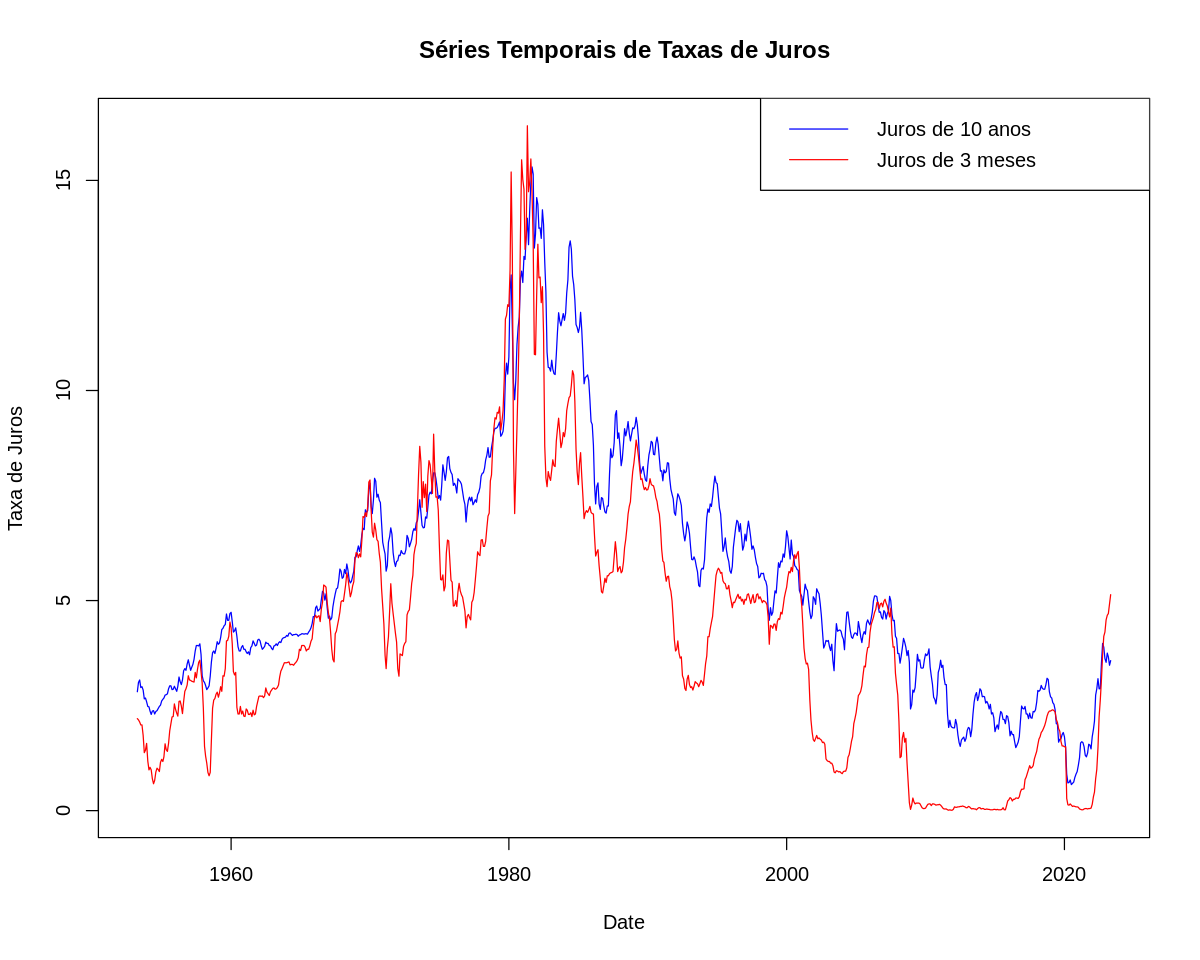

In [8]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Definir os limites dos eixos y
ylim <- range(c(gs_tb_diff_df$TB3MS, gs_tb_diff_df$GS10))

# Plotar a série GS10 em azul
plot(gs_tb_diff_df$date, gs_tb_diff_df$GS10, type = "l", col = "blue", xlab = "Date", ylab = "Taxa de Juros", ylim = ylim)

# Adicionar a série TB3MS em vermelho
lines(gs_tb_diff_df$date, gs_tb_diff_df$TB3MS, col = "red")

# Adicionar uma legenda
legend("topright", legend = c("Juros de 10 anos", "Juros de 3 meses"), col = c("blue", "red"), lty = 1)

# Adicionar título ao gráfico
title(main = "Séries Temporais de Taxas de Juros")

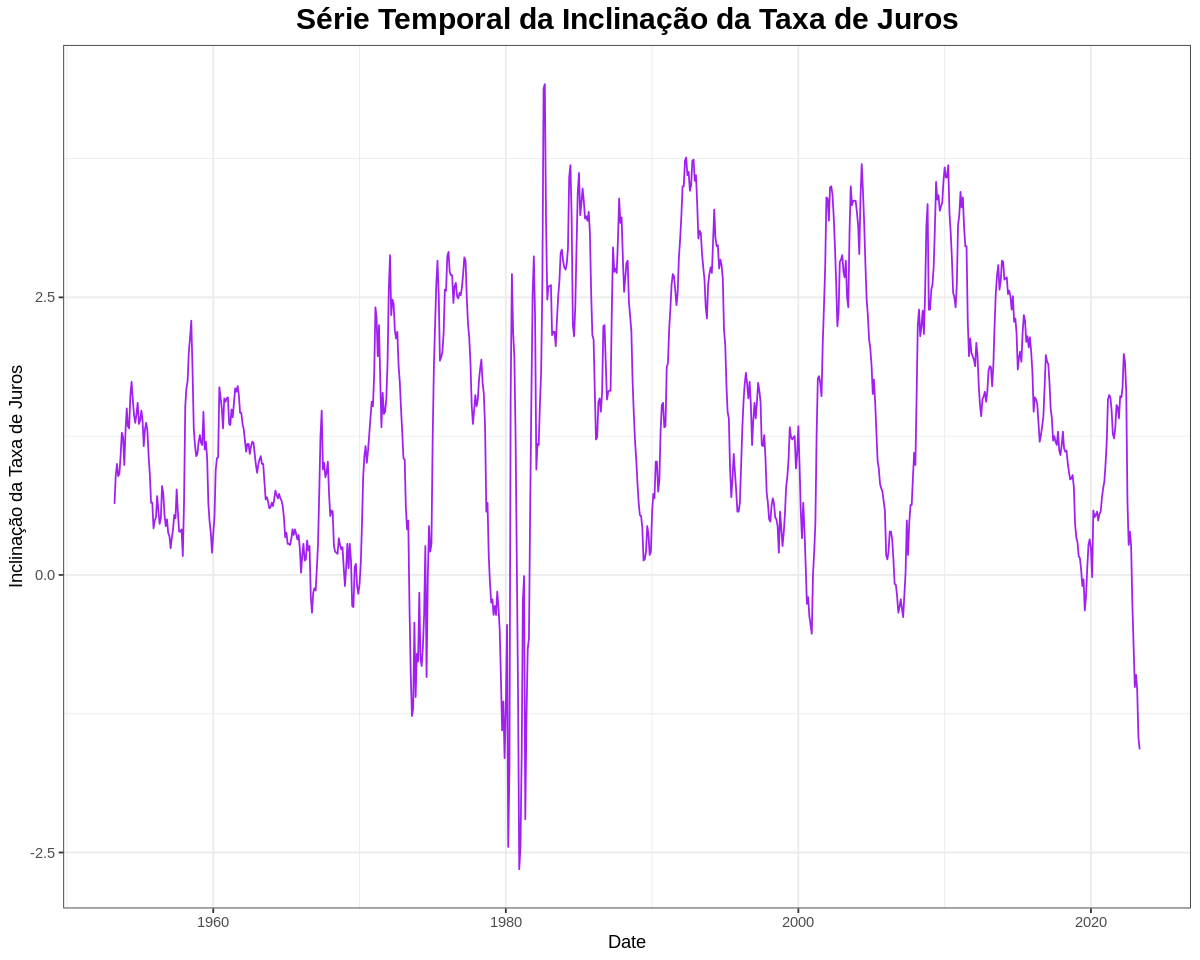

In [9]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Criar o objeto de plotagem usando ggplot
p <- ggplot(gs_tb_diff_df, aes(x = date, y = SLOPE)) +
  geom_line(color = "purple") +
  labs(x = "Date", y = "Inclinação da Taxa de Juros") +
  ggtitle("Série Temporal da Inclinação da Taxa de Juros") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

# Exibir o gráfico
print(p)

> ##### *b. Faça um gráfico com a taxa de desemprego ao longo do tempo.*

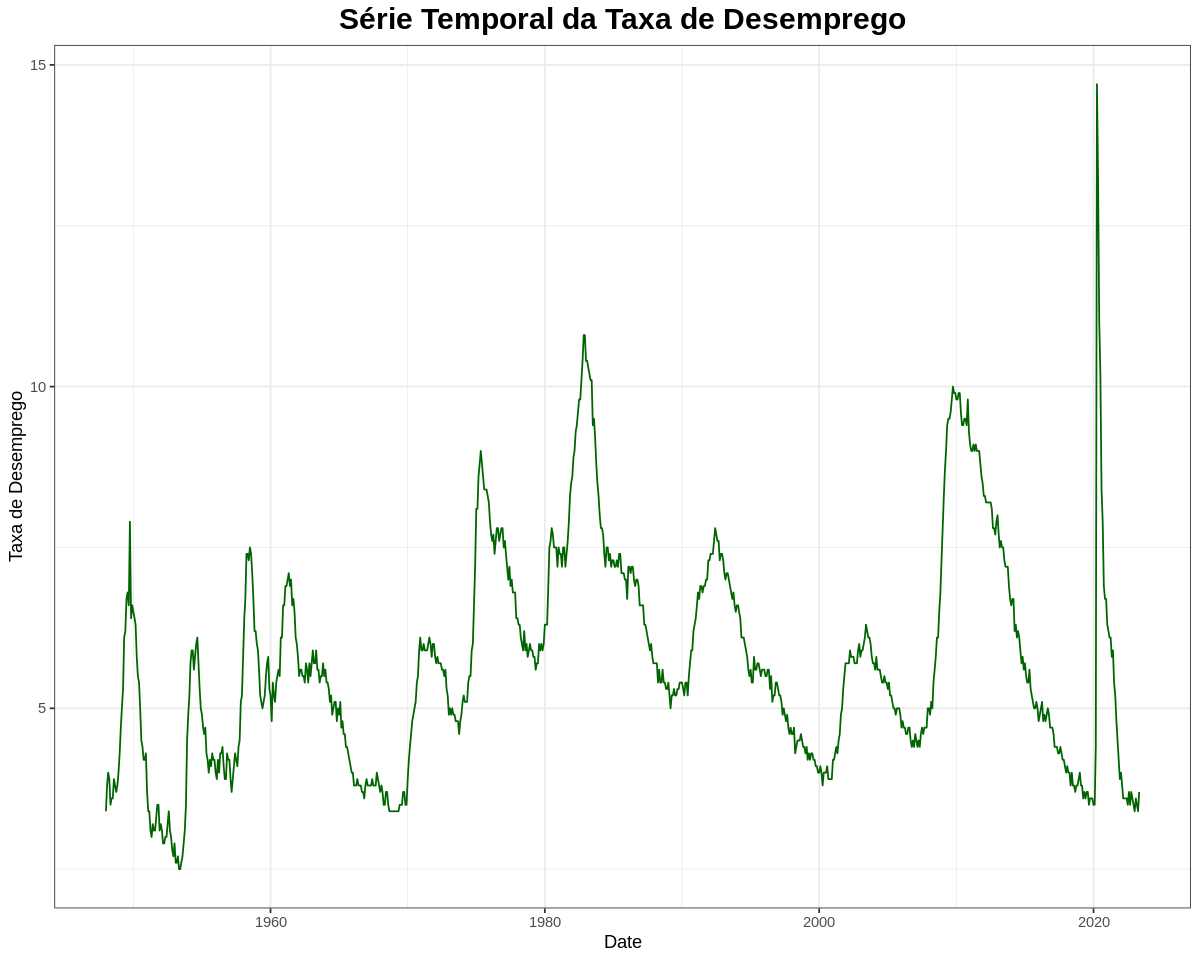

In [10]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Criar o objeto de plotagem usando ggplot
p <- ggplot(unrate_df, aes(x = date, y = UNRATE)) +
  geom_line(color = "darkgreen") +
  labs(x = "Date", y = "Taxa de Desemprego") +
  ggtitle("Série Temporal da Taxa de Desemprego") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

# Exibir o gráfico
print(p)

> ##### *c. Com as mesmas séries dos itens (a) e (b), faça dois gráficos que tenham não apenas as variáveis ao longo do tempo, mas também que as áreas hachuradas representem as recessões datadas pelo NBER.*

In [11]:
# Recessões datadas pelo NBER
recessions <- read.table(textConnection(
  "Peak, Trough
  1857-06-01, 1858-12-01
  1860-10-01, 1861-06-01
  1865-04-01, 1867-12-01
  1869-06-01, 1870-12-01
  1873-10-01, 1879-03-01
  1882-03-01, 1885-05-01
  1887-03-01, 1888-04-01
  1890-07-01, 1891-05-01
  1893-01-01, 1894-06-01
  1895-12-01, 1897-06-01
  1899-06-01, 1900-12-01
  1902-09-01, 1904-08-01
  1907-05-01, 1908-06-01
  1910-01-01, 1912-01-01
  1913-01-01, 1914-12-01
  1918-08-01, 1919-03-01
  1920-01-01, 1921-07-01
  1923-05-01, 1924-07-01
  1926-10-01, 1927-11-01
  1929-08-01, 1933-03-01
  1937-05-01, 1938-06-01
  1945-02-01, 1945-10-01
  1948-11-01, 1949-10-01
  1953-07-01, 1954-05-01
  1957-08-01, 1958-04-01
  1960-04-01, 1961-02-01
  1969-12-01, 1970-11-01
  1973-11-01, 1975-03-01
  1980-01-01, 1980-07-01
  1981-07-01, 1982-11-01
  1990-07-01, 1991-03-01
  2001-03-01, 2001-11-01
  2007-12-01, 2009-06-01
  2020-02-01, 2021-06-01"
), sep = ',', colClasses = c('Date', 'Date'), header = TRUE)

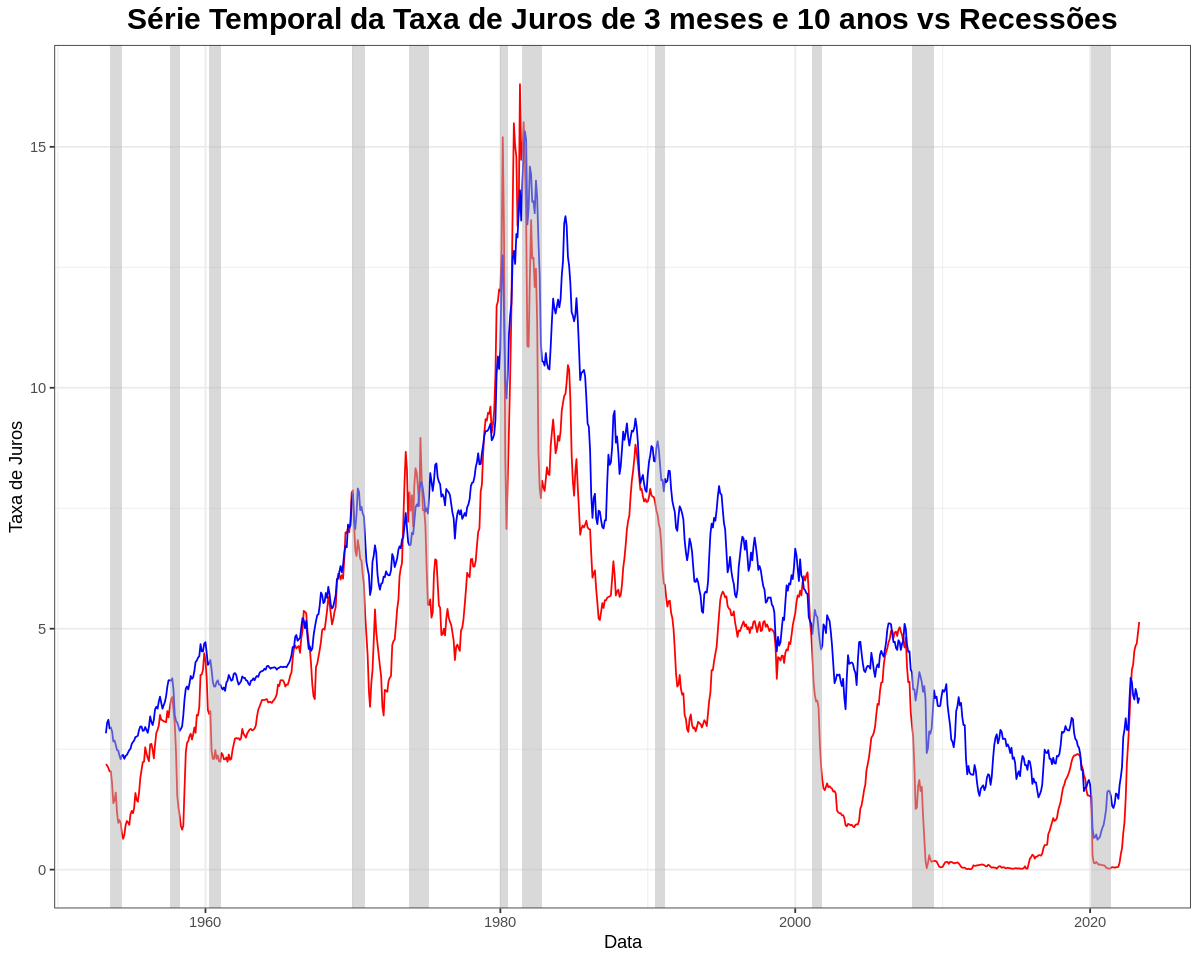

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Criar o dataframe para as áreas hachuradas
recessions <- recessions[recessions$Peak >= min(gs_tb_diff_df$date) & recessions$Trough <= max(gs_tb_diff_df$date), ]

# Criar o objeto de plotagem
p <- ggplot() +
  geom_line(data = gs_tb_diff_df, aes(x = date, y = TB3MS), color = "red") +  # Linha TB3MS em vermelho
  geom_line(data = gs_tb_diff_df, aes(x = date, y = GS10), color = "blue") +  # Linha GS10 em azul
  geom_rect(data = recessions, aes(xmin = Peak, xmax = Trough, ymin = -Inf, ymax = Inf), fill = "gray70", alpha = 0.5, inherit.aes = FALSE) +
  labs(x = "Data", y = "Taxa de Juros", title = "Série Temporal da Taxa de Juros de 3 meses e 10 anos vs Recessões") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

# Ajustar a escala dos eixos para cobrir todo o intervalo de datas
p <- p + scale_x_date(limits = c(min(gs_tb_diff_df$date), max(gs_tb_diff_df$date)))

# Exibir o gráfico
print(p)

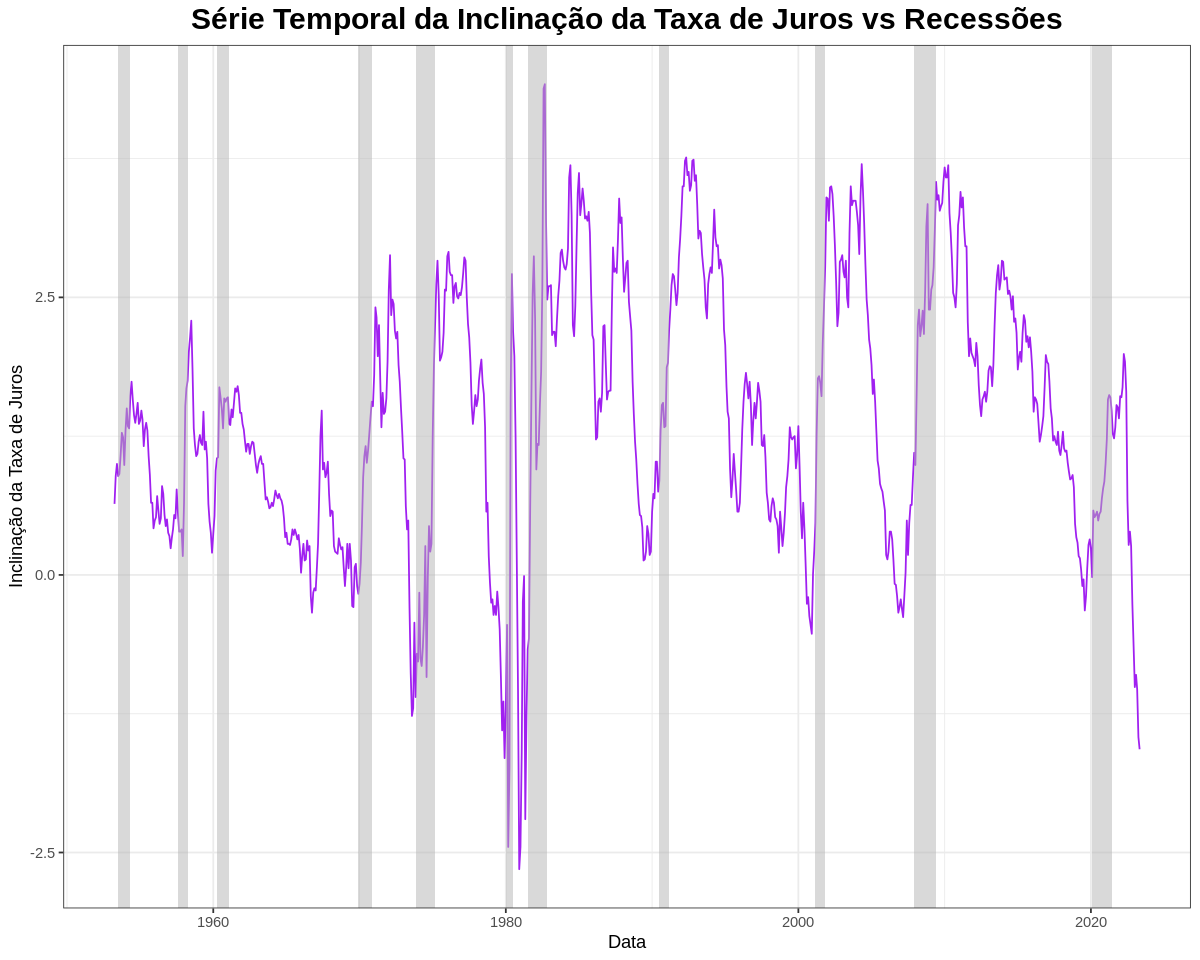

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Criar o dataframe para as áreas hachuradas
recessions <- recessions[recessions$Peak >= min(gs_tb_diff_df$date) & recessions$Trough <= max(gs_tb_diff_df$date), ]

# Criar o objeto de plotagem
p <- ggplot() +
  geom_line(data = gs_tb_diff_df, aes(x = date, y = SLOPE), color = "purple") +
  geom_rect(data = recessions, aes(xmin = Peak, xmax = Trough, ymin = -Inf, ymax = Inf), fill = "gray70", alpha = 0.5, inherit.aes = FALSE) +
  labs(x = "Data", y = "Inclinação da Taxa de Juros") +
  ggtitle("Série Temporal da Inclinação da Taxa de Juros vs Recessões") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

# Ajustar a escala dos eixos para cobrir todo o intervalo de datas
p <- p + scale_x_date(limits = c(min(gs_tb_diff_df$date), max(gs_tb_diff_df$date)))

# Exibir o gráfico
print(p)

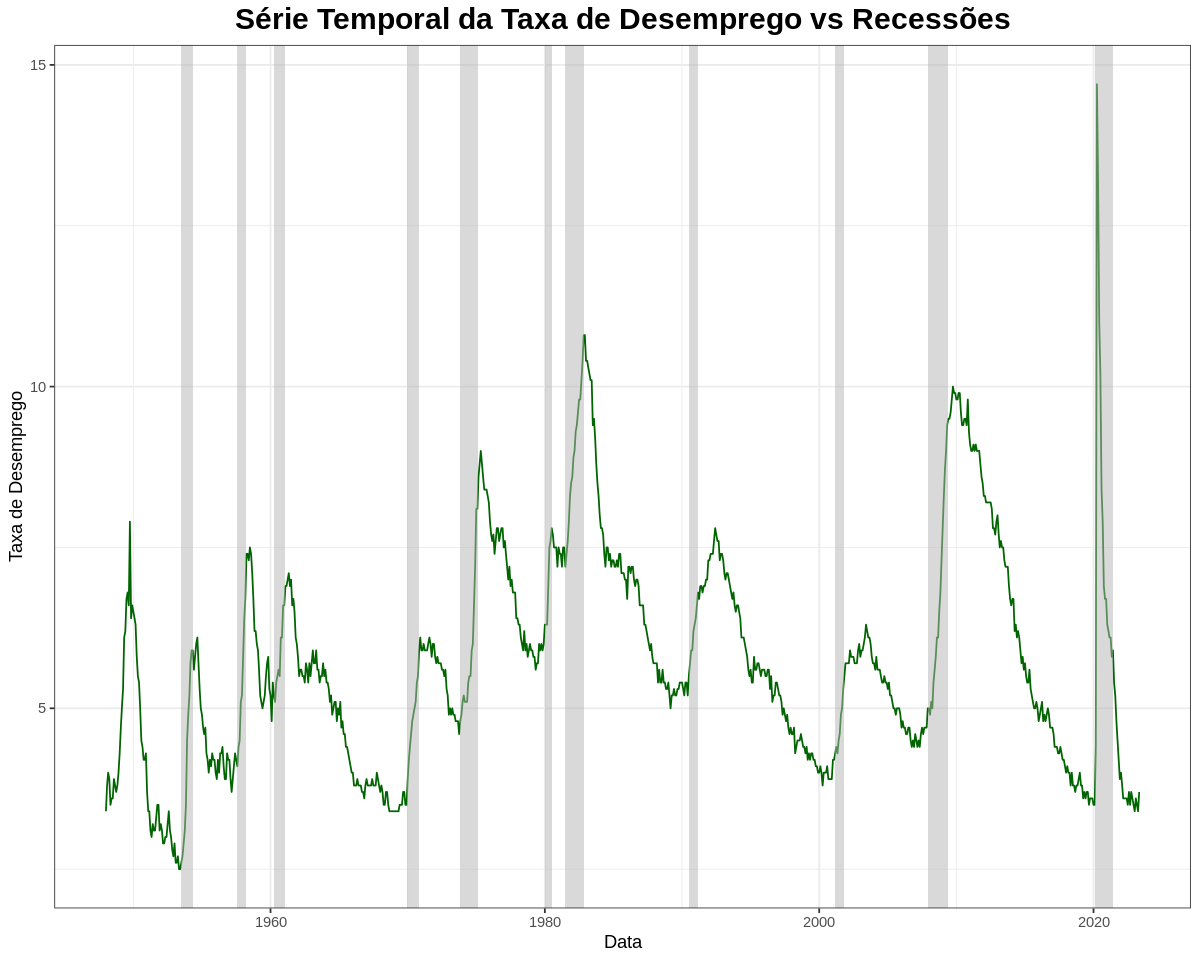

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 10, repr.plot.height = 8)

# Criar o dataframe para as áreas hachuradas
recessions <- recessions[recessions$Peak >= min(unrate_df$date) & recessions$Trough <= max(unrate_df$date), ]

# Criar o objeto de plotagem
p <- ggplot() +
  geom_line(data = unrate_df, aes(x = date, y = UNRATE), color = "darkgreen") +
  geom_rect(data = recessions, aes(xmin = Peak, xmax = Trough, ymin = -Inf, ymax = Inf), fill = "gray70", alpha = 0.5, inherit.aes = FALSE) +
  labs(x = "Data", y = "Taxa de Desemprego") +
  ggtitle("Série Temporal da Taxa de Desemprego vs Recessões") +
  theme_bw() +
  theme(plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

# Ajustar a escala dos eixos para cobrir todo o intervalo de datas
p <- p + scale_x_date(limits = c(min(unrate_df$date), max(unrate_df$date)))

# Exibir o gráfico
print(p)

#### **3. Descreva os gráficos**

- Com base nos gráficos dos itens anteriores, descreva os padrões
observados.

**Taxa de Juros**

Para os períodos observados de recessão, percebe-se que houveram picos de crescimento na inclinação da taxa de juros, isso porque a taxa de juros de 3 meses reduziu com maior intensidade em comparação com a taxa de juros de 10 anos, tornando assim a diferença entre taxas mais acentuada em momentos de recessão.

Esse efeito se dá porque a taxa de 3 meses  é influenciada diretamente pelas decisões do banco central, enquanto a taxa de juros de longo prazo de 10 anos, é determinada principalmente pelas expectativas de inflação e pelo equilíbrio entre oferta e demanda de títulos de prazo mais longo. Durante uma recessão, o banco central geralmente reduz a taxa de juros de curto prazo de forma mais agressiva para estimular o crédito e o investimento imediato.

**Taxa de Desemprego**

Para os períodos observados no gráfico acima, pode-se observar que em momentos de recessão acontece um aumento abrupto da taxa de desemprego por conta da redução da atividade econômica, o corte de gastos das empresas e a redução da confiança e investimento empresarial.

#### **4. Vamos criar um `dataframe`**

- Crie um `dataframe` chamado `data` com as seguintes variáveis: `USREC`, `SLOPE` e `UNRATE`.

In [ ]:
# Juntar os dataframes usando a coluna "date" como chave de junção
merged_df <- merge(usrec_df, unrate_df, by = "date")
data <- merge(merged_df, gs_tb_diff_df[, c("date", "SLOPE")], by = "date")

In [ ]:
tail(data, 5)

,date,USREC,UNRATE,SLOPE
,<date>,<int>,<dbl>,<dbl>
838,2023-01-01,0,3.4,-1.01
839,2023-02-01,0,3.6,-0.90
840,2023-03-01,0,3.5,-1.03
841,2023-04-01,0,3.4,-1.46
842,2023-05-01,0,3.7,-1.57


#### **5. Primeira abordagem (modelo de regressão linear)**

> ##### *a. Faça uma regressão linear simples do indicador de recessões do NBER na inclinação da curva de juros.*

In [ ]:
linear_slope <- lm( USREC ~ SLOPE, data = data)

In [ ]:
summary(linear_slope)


Call:
lm(formula = USREC ~ SLOPE, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1558 -0.1383 -0.1333 -0.1267  0.8816 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.141742   0.018549   7.642 5.85e-14 ***
SLOPE       -0.005291   0.010068  -0.525    0.599    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3412 on 840 degrees of freedom
Multiple R-squared:  0.0003286,	Adjusted R-squared:  -0.0008615 
F-statistic: 0.2761 on 1 and 840 DF,  p-value: 0.5994


> ##### *b. Faça uma regressão linear simples do indicador de recessões do NBER na taxa de desemprego.*

In [ ]:
linear_unrate <- lm( USREC ~ UNRATE, data = data)

In [ ]:
summary(linear_unrate)


Call:
lm(formula = USREC ~ UNRATE, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31629 -0.15002 -0.12097 -0.08697  0.94331 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.010067   0.042309  -0.238  0.81198    
UNRATE       0.024724   0.006969   3.548  0.00041 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3387 on 840 degrees of freedom
Multiple R-squared:  0.01476,	Adjusted R-squared:  0.01359 
F-statistic: 12.59 on 1 and 840 DF,  p-value: 0.0004102


> ##### *c. Faça uma regressão linear múltipla com as todas as variáveis.*

In [ ]:
linear_model <- lm( USREC ~ SLOPE + UNRATE, data = data)

In [ ]:
summary(linear_model)


Call:
lm(formula = USREC ~ SLOPE + UNRATE, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44624 -0.14529 -0.11414 -0.08221  0.96726 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.038210   0.043173  -0.885  0.37639    
SLOPE       -0.035197   0.011882  -2.962  0.00314 ** 
UNRATE       0.038141   0.008285   4.604 4.79e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3372 on 839 degrees of freedom
Multiple R-squared:  0.02496,	Adjusted R-squared:  0.02263 
F-statistic: 10.74 on 2 and 839 DF,  p-value: 2.484e-05


> ##### *d. Explique os resultados.*

O modelo de regressão linear não representa uma abordagem adequada, porque a regressão linear pressupõe uma relação linear entre as variáveis independentes e dependentes, mas a variável `USREC` é binária.

Além disso, a regressão linear pode produzir valores contínuos em toda a faixa dos números reais, mas uma variável binária só pode assumir dois valores distintos.

#### **6. Segunda abordagem (Probit)**

> ##### *a. Faça um modelo Probit do indicador de recessões do NBER na inclinação da curva de juros.*

In [ ]:
probit_slope <- glm( USREC ~ SLOPE, data = data, family = binomial(link = "probit"))

In [ ]:
print( tidy(probit_slope) )

# A tibble: 2 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)  -1.07      0.0846   -12.7   8.65e-37
2 SLOPE        -0.0245    0.0465    -0.528 5.97e- 1


In [ ]:
round( PseudoR2( probit_slope, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           0.08

> ##### *b. Faça um modelo Probit do indicador de recessões do NBER na taxa de desemprego.*

In [ ]:
probit_unrate <- glm( USREC ~ UNRATE, data = data, family = binomial(link = "probit"))

In [ ]:
print( tidy(probit_unrate) )

# A tibble: 2 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)   -1.75     0.198      -8.85 8.68e-19
2 UNRATE         0.107    0.0312      3.43 5.95e- 4


In [ ]:
round( PseudoR2( probit_unrate, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           3.12

> ##### *c. Faça um modelo Probit com as todas as variáveis.*

In [ ]:
probit_model <- glm( USREC ~ SLOPE + UNRATE, data = data, family = binomial(link = "probit"))

In [ ]:
print( tidy(probit_model) )

# A tibble: 3 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)   -1.84     0.201      -9.17 4.88e-20
2 SLOPE         -0.141    0.0535     -2.64 8.17e- 3
3 UNRATE         0.155    0.0364      4.27 1.98e- 5


In [ ]:
round( PseudoR2( probit_model, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           4.58

In [ ]:
# Obter o valor mais recente da série temporal SLOPE
valor_slope <- tail(data$SLOPE, n = 1)

# Obter o valor mais recente da série temporal UNRATE
valor_unrate <- tail(data$UNRATE, n = 1)

# Criar o novo conjunto de dados para previsão com os valores mais recentes
new_data <- data.frame(SLOPE = valor_slope, UNRATE = valor_unrate)

# Fazer a previsão de probabilidade de recessão para o novo conjunto de dados
prob_recessao <- predict(probit_model, newdata = new_data, type = "response")

# Exibir a probabilidade de recessão
paste("Probabilidade de recessão:", round(100*prob_recessao,2), "%")

[1] "Probabilidade de recessão: 14.89 %"

#### **7. Terceira abordagem (Logit)**

> ##### *a. Faça um modelo Logit do indicador de recessões do NBER na inclinação da curva de juros.*

In [ ]:
logit_slope <- glm( USREC ~ SLOPE, data = data, family = binomial(link = "logit"))

In [ ]:
print( tidy(logit_slope) )

# A tibble: 2 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)  -1.80      0.156    -11.5   1.03e-30
2 SLOPE        -0.0454    0.0864    -0.526 5.99e- 1


In [ ]:
round( PseudoR2( logit_slope, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           0.09

> ##### *b. Faça um modelo Logit do indicador de recessões do NBER na taxa de desemprego.*

In [ ]:
logit_unrate <- glm( USREC ~ UNRATE, data = data, family = binomial(link = "logit"))

In [ ]:
print( tidy(logit_unrate) )

# A tibble: 2 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)   -3.04     0.365      -8.34 7.65e-17
2 UNRATE         0.195    0.0561      3.47 5.13e- 4


In [ ]:
round( PseudoR2( logit_unrate, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           3.14

> ##### *c. Faça um modelo Logit com as todas as variáveis.*

In [ ]:
logit_model <- glm( USREC ~ SLOPE + UNRATE, data = data, family = binomial(link = "logit"))

In [ ]:
print( tidy(logit_model) )

# A tibble: 3 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)   -3.19     0.368      -8.67 4.34e-18
2 SLOPE         -0.254    0.0957     -2.65 7.95e- 3
3 UNRATE         0.280    0.0645      4.34 1.44e- 5


In [ ]:
round( PseudoR2( logit_model, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
           4.52

In [ ]:
# Obter o valor mais recente da série temporal SLOPE
valor_slope <- tail(data$SLOPE, n = 1)

# Obter o valor mais recente da série temporal UNRATE
valor_unrate <- tail(data$UNRATE, n = 1)

# Criar o novo conjunto de dados para previsão com os valores mais recentes
new_data <- data.frame(SLOPE = valor_slope, UNRATE = valor_unrate)

# Fazer a previsão de probabilidade de recessão para o novo conjunto de dados
prob_recessao <- predict(logit_model, newdata = new_data, type = "response")

# Exibir a probabilidade de recessão
paste("Probabilidade de recessão:", round(100*prob_recessao,2), "%")

[1] "Probabilidade de recessão: 14.69 %"

#### **8. Probit: a estimativa**

- Lembre-se da pergunta que queremos responder: Qual é a probabilidade de os EUA entrarem em recessão nos próximos 12 meses?

- Como a pergunta diz respeito à 12 meses à frente, é importante criar uma variável que seja o indicador de recessão em 12 meses.

In [ ]:
data <- data %>%
  mutate(USREC_LEAD12 = lead(USREC, n = 12))

> Estime o modelo.

In [ ]:
probit_model_12 <- glm( USREC_LEAD12 ~ SLOPE + UNRATE, data = data, family = binomial(link = "probit"))

In [ ]:
print( tidy(probit_model_12) )

# A tibble: 3 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)  -0.252     0.247     -1.02  3.09e- 1
2 SLOPE        -0.728     0.0772    -9.42  4.43e-21
3 UNRATE       -0.0373    0.0482    -0.774 4.39e- 1


In [ ]:
round( PseudoR2( probit_model_12, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
          43.27

In [ ]:
# Obter o valor mais recente da série temporal SLOPE
valor_slope <- tail(data$SLOPE, n = 1)

# Obter o valor mais recente da série temporal UNRATE
valor_unrate <- tail(data$UNRATE, n = 1)

# Criar o novo conjunto de dados para previsão com os valores mais recentes
new_data <- data.frame(SLOPE = valor_slope, UNRATE = valor_unrate)

# Fazer a previsão de probabilidade de recessão para o novo conjunto de dados
prob_recessao <- predict(probit_model_12, newdata = new_data, type = "response")

# Exibir a probabilidade de recessão
paste("Probabilidade de recessão em 12 meses:", round(100*prob_recessao,2), "%")

[1] "Probabilidade de recessão em 12 meses: 77.43 %"

 > **Qual é a conclusão?**

 - Avaliando o resultado do PseudoR2, pode-se concluir que o modelo Probit possui uma qualidade melhor para prever uma recessão daqui 12 meses em vez de prever uma recessão no mês vigente da estimativa.

#### **9. Probit: uma nova estimativa**

- Refaça a análise do item 6, mas considere agora a probabilidade de uma recessão em 6 meses.

In [ ]:
data <- data %>%
  mutate(USREC_LEAD06 = lead(USREC, n = 6))

In [ ]:
probit_model_06 <- glm( USREC_LEAD06 ~ SLOPE + UNRATE, data = data, family = binomial(link = "probit"))

In [ ]:
print( tidy(probit_model_06) )

# A tibble: 3 × 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept) -0.542      0.217     -2.50  1.26e- 2
2 SLOPE       -0.480      0.0626    -7.67  1.73e-14
3 UNRATE      -0.00710    0.0417    -0.170 8.65e- 1


In [ ]:
round( PseudoR2( probit_model_06, which = "McKelveyZavoina" ) * 100, 2 )

McKelveyZavoina 
          23.84

In [ ]:
# Obter o valor mais recente da série temporal SLOPE
valor_slope <- tail(data$SLOPE, n = 1)

# Obter o valor mais recente da série temporal UNRATE
valor_unrate <- tail(data$UNRATE, n = 1)

# Criar o novo conjunto de dados para previsão com os valores mais recentes
new_data <- data.frame(SLOPE = valor_slope, UNRATE = valor_unrate)

# Fazer a previsão de probabilidade de recessão para o novo conjunto de dados
prob_recessao <- predict(probit_model_06, newdata = new_data, type = "response")

# Exibir a probabilidade de recessão
paste("Probabilidade de recessão em 6 meses:", round(100*prob_recessao,2), "%")

[1] "Probabilidade de recessão em 6 meses: 57.36 %"

 > **Qual é a conclusão?**

 - Avaliando o resultado do PseudoR2, pode-se concluir que o modelo Probit possui uma qualidade melhor para prever uma recessão daqui 6 meses em vez de prever uma recessão no mês vigente da estimativa, mas a previsão de recessão em 12 meses ainda é melhor que a previsão em 6 meses.